In [61]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
from analysis_tools import getobjdata

import scipy.ndimage as ndimage
import matplotlib.colors as mcolors

from colormaps import radar_colormap

#from Plot_tools import *
from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.cbook import pickle2Obj

_nthreads = 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
models = {'cm1': pickle2Obj('object_stat/cm1_squall_3km_obj.pkl',retObj=False) }

In [48]:
models['wrf'] = pickle2Obj('object_stat/wrf_squall_3km_obj.pkl', retObj=False)

In [49]:
models['solo'] = pickle2Obj('object_stat/solo_squall_3km_obj.pkl',retObj=False)

In [5]:
#models['mpas'] = pickle2Obj('object_stat/mpas_squall_3km_obj.pkl',retObj=False)

In [50]:
for key in models:
    for key2 in models[key]['C2000_06']:
        print(key, key2, models[key]['C2000_06'][key2].shape)

cm1 dbz (25, 60, 256, 256)
cm1 hgt (25, 60, 256, 256)
cm1 w (25, 60, 256, 256)
cm1 buoy (25, 60, 256, 256)
cm1 qr (25, 60, 256, 256)
cm1 pres (25, 60, 256, 256)
cm1 pert_th (25, 60, 256, 256)
wrf dbz (25, 60, 255, 255)
wrf hgt (25, 60, 255, 255)
wrf w (25, 60, 255, 255)
wrf buoy (25, 60, 255, 255)
wrf qr (25, 60, 255, 255)
wrf pres (25, 60, 255, 255)
wrf pert_th (25, 60, 255, 255)
solo dbz (24, 60, 256, 256)
solo hgt (24, 60, 256, 256)
solo w (24, 60, 256, 256)
solo buoy (24, 60, 256, 256)
solo qr (24, 60, 256, 256)
solo pres (24, 60, 256, 256)
solo pert_th (24, 60, 256, 256)


In [77]:
#-----------------------------------------------------------------
def run_spectral_analysis(model, run, analysis_levels, var='w'):
    
    # Loop over the analy_klevels to create multiple plots

    for n, k in enumerate(analysis_levels):

        # these five levels are averaged together

        klevels = [k-2, k-1, k, k+1, k+2]
        
    # set plot up for each level
        
        fig = plt.figure(constrained_layout=True,figsize=(10,10))

        ylim    = [0.1,1.0e4]
        axis    = 0
        func    = get_spectra2D_DCT
        PSonly  = True

        gs = gridspec.GridSpec(1, 1, figure=fig)

        ax = fig.add_subplot(gs[0, 0])
        
    # process and plot w fields from models
    
        for key in models:
                
            model_data = models[key][run][var][0:12,klevels,:,:]

        # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            w = np.nan_to_num(model_data).astype('float64')
            
            zlevel =  models[key][run]['hgt'][0,klevels[2],-1,-1]

        # Compute spectra...
        
            if key == 'solo':   
                plot_spectra(w, func=func, ax=ax, legend='', linecolor='r', PSline='-', ylim=ylim, LineOnly=True)
                                                
            if key == 'cm1':
                plot_spectra(w, func=func, ax=ax, legend='', linecolor='b', PSline='-', ylim=ylim, LineOnly=True)
                    
            if key == 'wrf':
                plot_spectra(w, func=func, ax=ax, linecolor='k', PSline='-', ylim=ylim, 
                             legend='WRF-2D:black/solid\nWRF-2D:black/dash\nFV3:red/solid', 
                             ptitle = 'W Pow_Spec')
                    
            if key == 'mpas':
                plot_spectra(w, func=func, ax=ax, linecolor='g', PSline='-', 
                             legend='WRF-2D:black/solid\nWRF-2D:black/dash\nFV3:red/solid', 
                             ptitle = 'W Pow_Spec', ylim=ylim)

        plt.suptitle("W-Spectra Avg for run: %s Height Level: %f km" % (run, zlevel/1000.), fontsize=14)

#         plt.savefig("%s/spectra_%s_%s_%3.3dhPa.png" % (out_dir, 'W_ideal', shear, plevels[n]/100), bbox_inches='tight', dpi=300)

        

----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_DCT
plot_spectra: Spectrum from a single variable
plot_spectra: DETREND = False

          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 60

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_DCT is now being called


----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_DCT
plot_spectra: Spectrum from a single variable
plot_spectra: DETREND = False

          ----------------------------------------------------------------------------------------------------
    

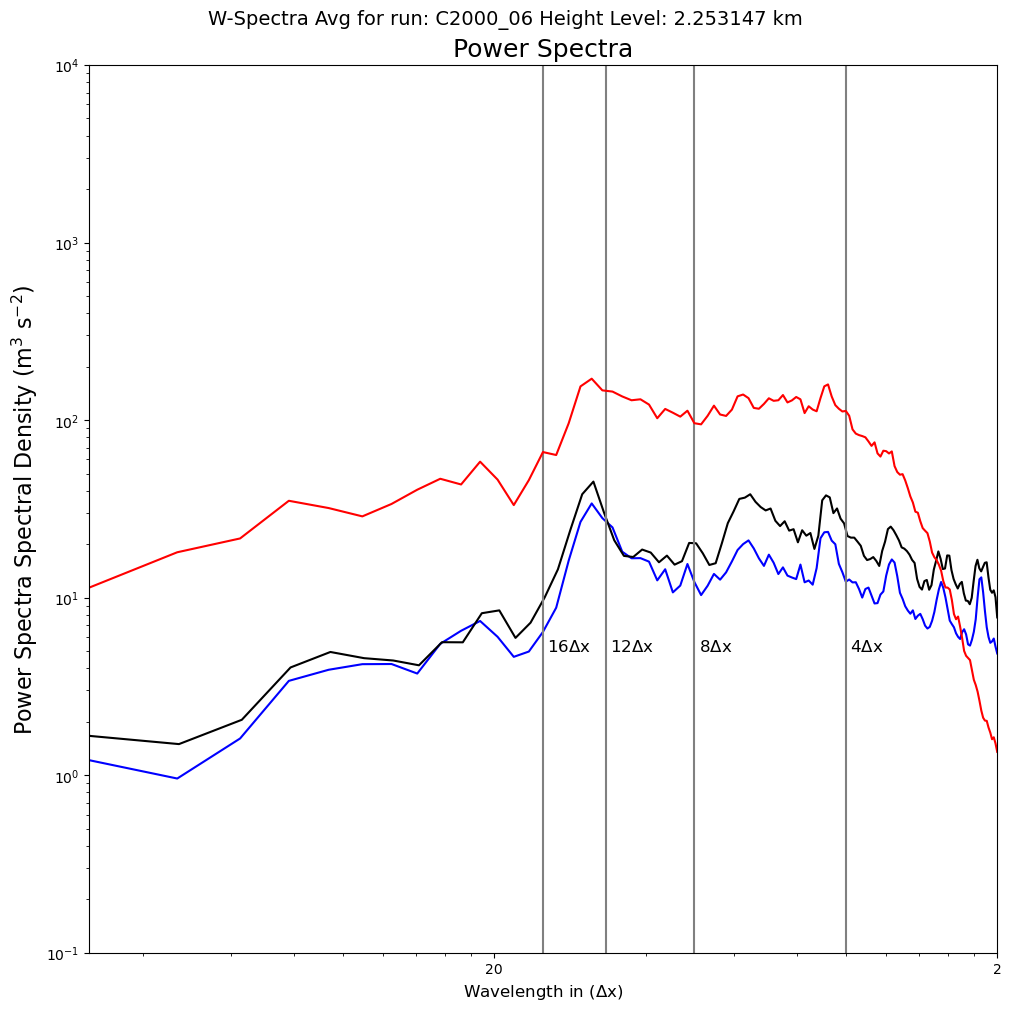

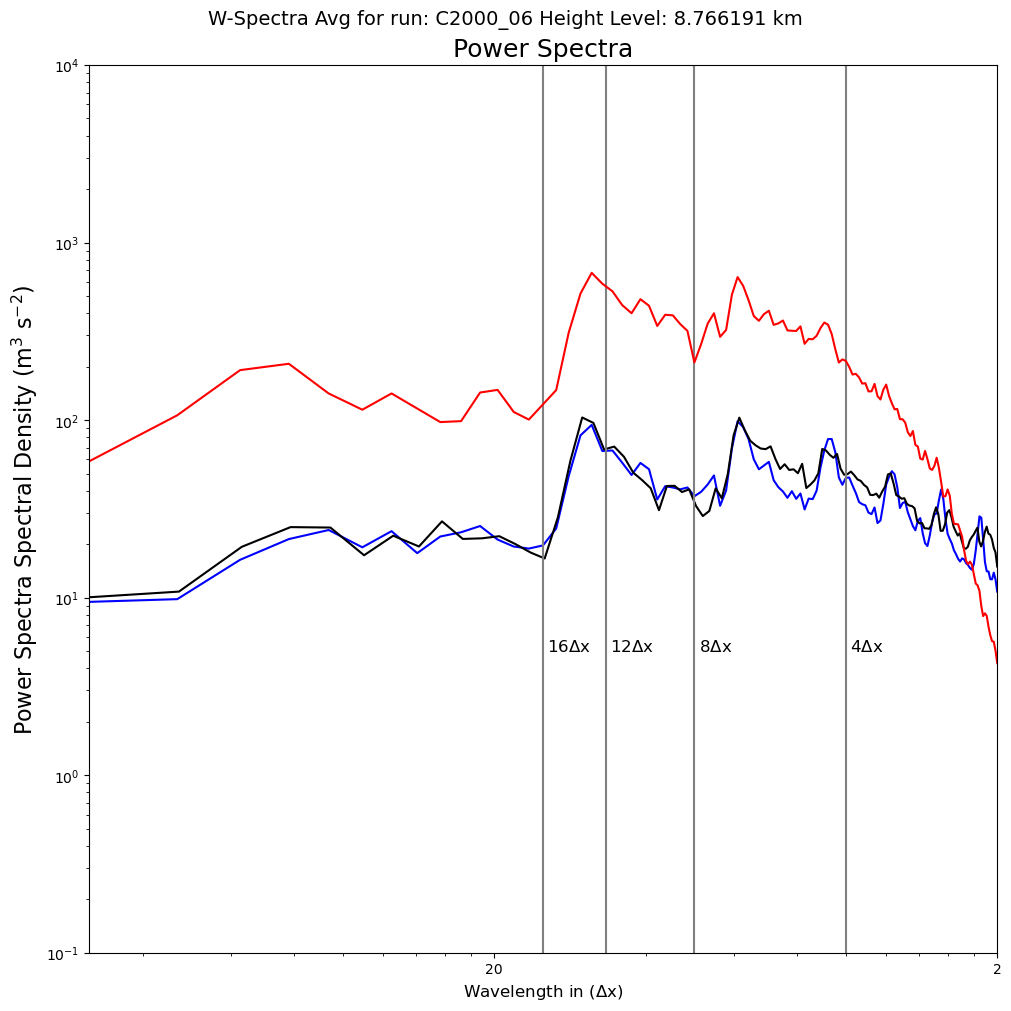

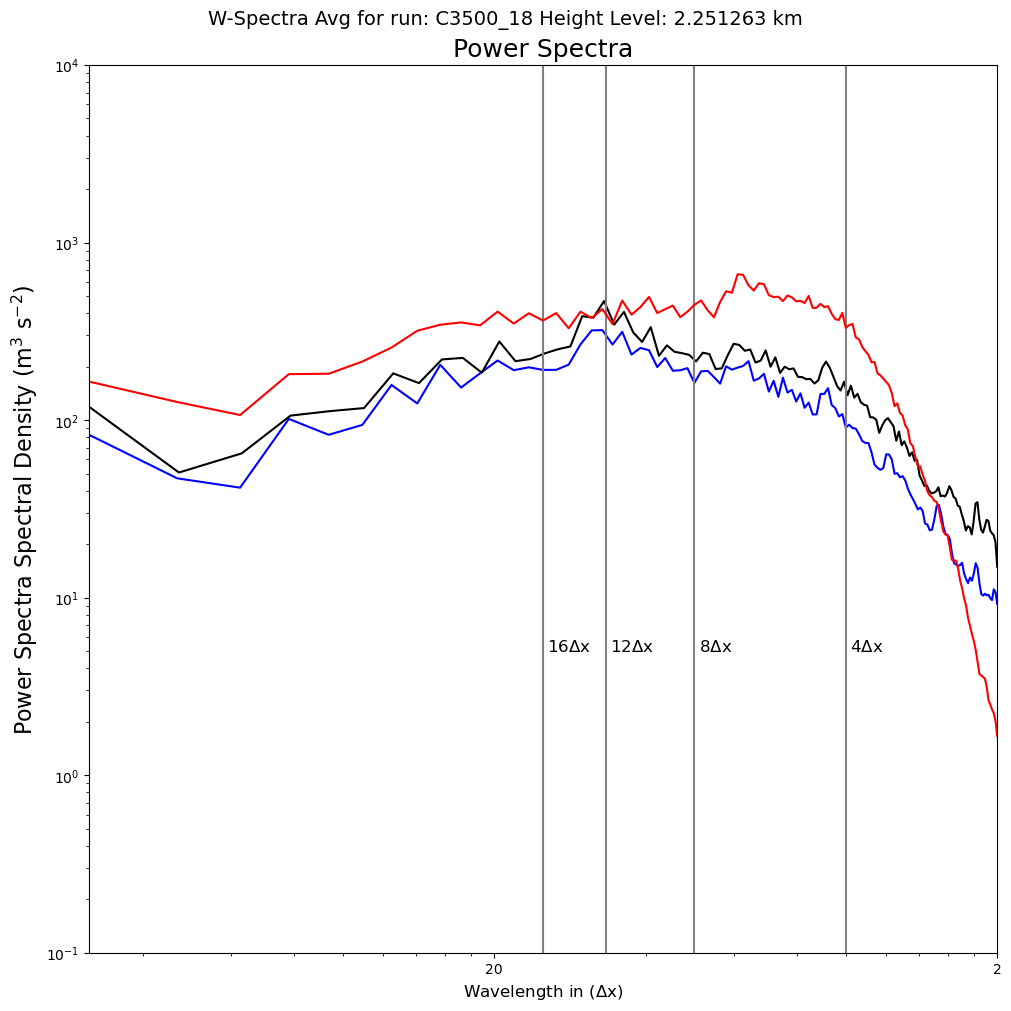

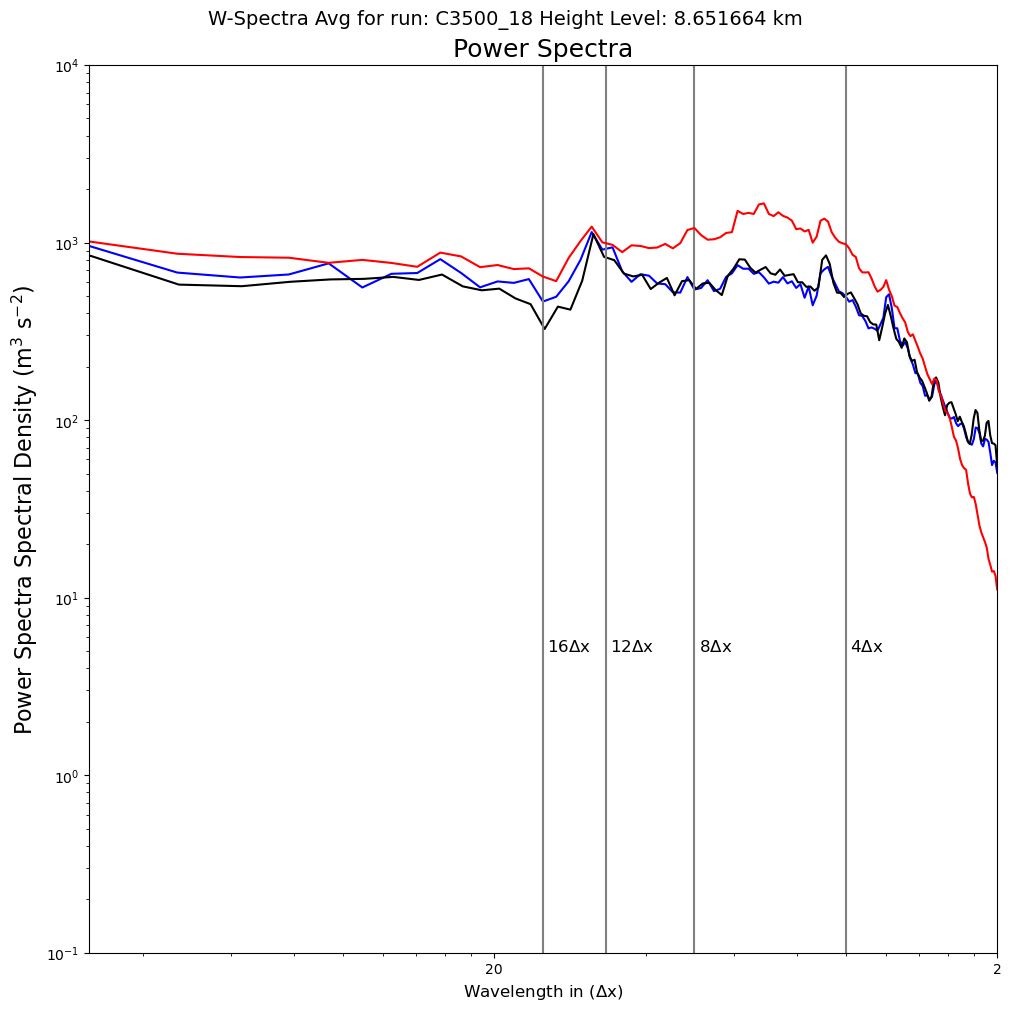

In [80]:
# Local import 

from spectra.py_spectra import *

#print(models['wrf']["C2000_06"]['w'])

ret = run_spectral_analysis(models, "C2000_06", [15], var='w')
ret = run_spectral_analysis(models, "C2000_06", [35], var='w')
et = run_spectral_analysis(models, "C3500_18", [15], var='w')
ret = run_spectral_analysis(models, "C3500_18", [35], var='w')

In [36]:
# Input data sets....

from input_default import input_all as input_config
import matplotlib.ticker as mticker

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

input_dir  = input_config["input_dir"]
output_dir = input_config["output_dir"]
ncases     = len(input_config["cases"])

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"hrrr":[], 
             "ctrl":[],
             "nam":[],
             "nord3":[]}

avg_data = {"hrrr" :np.zeros((ncases,avg_grid.shape[0],)), 
            "ctrl" :np.zeros((ncases,avg_grid.shape[0],)),
            "nam"  :np.zeros((ncases,avg_grid.shape[0],)),
            "nord3":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_AVG
axis = None

delta = False
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

analysis_levels  = [6,16,28]

for k in analysis_levels:
    for n, day in enumerate(input_config["cases"]):
        for run in input_config["cases"][day]:

            print("\n----> Processing run: %s for day:  %s \n" % (run,day))
            run_dir = str(os.path.join(input_dir, day, run))
            out_dir = str(os.path.join(output_dir, day, run))

            # Open data set

            data = open_mfdataset_list(run_dir , "region_*.nc")
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-2, k-1, k, k+1, k+2]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_w = np.nan_to_num(data.W.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = plot_spectra(data_w, func=func, ret_Data=True, no_Plot=True, print_info=False)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])


# Now post the runs....

    legend='HRRR:black\nCTRL:blue\nNORD3:red'

    avg_hrrr  = avg_data['hrrr'].mean(axis=0)
    avg_ctrl  = avg_data['ctrl'].mean(axis=0)
    avg_nord3 = avg_data['nord3'].mean(axis=0)

    avg_nam   = avg_data['nam'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_nord = avg_nord3[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_nord,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_ctrl,  color='blue')
    axes.loglog(avg_grid, avg_nord3, color='red')
    axes.loglog(avg_grid, avg_nam, color='green')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [0.0001,10.0]
    
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5.

    xoffset = [0.01, 0.0075, 0.005, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([3.0, 4.0, 6.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"W Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    # plt.title(ptitle, fontsize=18)

    plt.suptitle("W_SPECTRA_ALL_DAYS: Pressure Level: %d hPa" % (plevels[k]/100), fontsize=16)

    plt.savefig("%s/spectra_%s_%3.3dhPa.png" % ('/work/wicker/CAM_analysis_tools', 'W_ALL', plevels[k]/100),bbox_inches='tight',dpi=300)



ModuleNotFoundError: No module named 'input_default'

In [16]:
avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)
print(avg_grid)

[0.005      0.01494949 0.02489899 0.03484848 0.04479798 0.05474747
 0.06469697 0.07464646 0.08459596 0.09454545 0.10449495 0.11444444
 0.12439394 0.13434343 0.14429293 0.15424242 0.16419192 0.17414141
 0.18409091 0.1940404  0.2039899  0.21393939 0.22388889 0.23383838
 0.24378788 0.25373737 0.26368687 0.27363636 0.28358586 0.29353535
 0.30348485 0.31343434 0.32338384 0.33333333 0.34328283 0.35323232
 0.36318182 0.37313131 0.38308081 0.3930303  0.4029798  0.41292929
 0.42287879 0.43282828 0.44277778 0.45272727 0.46267677 0.47262626
 0.48257576 0.49252525 0.50247475 0.51242424 0.52237374 0.53232323
 0.54227273 0.55222222 0.56217172 0.57212121 0.58207071 0.5920202
 0.6019697  0.61191919 0.62186869 0.63181818 0.64176768 0.65171717
 0.66166667 0.67161616 0.68156566 0.69151515 0.70146465 0.71141414
 0.72136364 0.73131313 0.74126263 0.75121212 0.76116162 0.77111111
 0.78106061 0.7910101  0.8009596  0.81090909 0.82085859 0.83080808
 0.84075758 0.85070707 0.86065657 0.87060606 0.88055556 0.89050

In [17]:
1/8.

0.125